# NFL 2020 Forecasting Yards Gained Using Regression

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from modeling import *
from visualizations import *
import pickle
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Data Preprocessing

In [81]:
# read data
cols = list(pd.read_csv('Data/cleaned_nfl.csv', nrows =1))
nfl = pd.read_csv('Data/cleaned_nfl.csv',
                  usecols =[i for i in cols if i != 'Yard_class'])
nfl.head()

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE


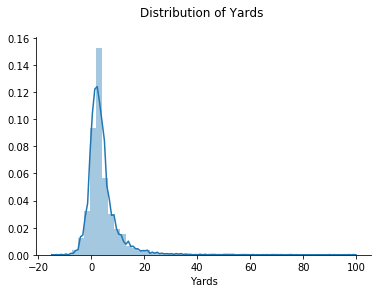

In [5]:
# plot distribution of number of yards
sns.distplot(nfl['Yards'])
sns.despine(left=False, bottom=False)
plt.title('Distribution of Yards \n')
plt.savefig('Images/Yards',
            bbox_inches='tight',
            transparent=True)

## Modeling

### Multiple Linear Regression

In [5]:
# define feature and target variables
X = nfl.drop('Yards', axis=1)
y = nfl['Yards']

# create dummy variables for categorical features
X = pd.get_dummies(X, drop_first=True)

In [6]:
# split datasets into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

**Scikit-learn Linear Regression**

In [13]:
linreg = LinearRegression().fit(X_train, y_train)
pickle.dump(linreg, open('Models/linreg.sav', 'wb'))

In [8]:
# load saved linear regression model
linreg = pickle.load(open('Models/linreg.sav', 'rb'))

# calculate score and print intercept and coefficients
print('Train Score:', linreg.score(X_train, y_train))
print('Intercept:', linreg.intercept_)
print('Coefficients:', linreg.coef_)

Train Score: 0.02913856596955977
Intercept: -661.3816856655743
Coefficients: [-2.07905026e-04  1.61336194e-04 -1.57659518e-01 ...  1.04602584e-01
  7.55910203e-02  2.05368375e-01]


**Statsmodels Linear Regression**

In [9]:
linreg_ols = sm.OLS(y_train,
                    sm.add_constant(X_train)).fit()

In [10]:
model_sum = linreg_ols.summary()
print(model_sum)

                            OLS Regression Results                            
Dep. Variable:                  Yards   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.993
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:50:08   Log-Likelihood:            -1.3322e+06
No. Observations:              407809   AIC:                         2.669e+06
Df Residuals:                  405371   BIC:                         2.696e+06
Df Model:                        2437                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [11]:
# Create a dataframe from our regression results
lin_table = linreg_ols.summary().tables[1]
lin_table = pd.DataFrame(lin_table.data)
lin_table.columns = lin_table.iloc[0]
lin_table.drop(0, inplace=True)
lin_table = lin_table.set_index(lin_table.columns[0])
lin_table = lin_table.astype(float)
lin_table.to_csv('Models/linreg.csv')
lin_table

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,-662.110900,97.235000,-6.809,0.000,-852.688000,-471.534000
long_axis,-0.000200,0.000000,-0.523,0.601,-0.001000,0.001000
short_axis,0.000200,0.001000,0.115,0.908,-0.003000,0.003000
speed,-0.157700,0.022000,-7.153,0.000,-0.201000,-0.114000
accel,0.102400,0.012000,8.711,0.000,0.079000,0.125000
Dis,0.860100,0.202000,4.249,0.000,0.463000,1.257000
Orientation,0.000051,0.000097,0.520,0.603,-0.000000,0.000000
Dir,0.000048,0.000096,0.500,0.617,-0.000000,0.000000
Season,0.361000,0.026000,14.113,0.000,0.311000,0.411000


#### Lasso

In [76]:
lin_l1 = LassoCV(cv=5, random_state=220)
lin_l1.fit(X_train, y_train)

pickle.dump(lin_l1, open('Models/lasso.sav', 'wb'))

In [77]:
lin_l1 = pickle.load(open('Models/lasso.sav', 'rb'))

print('Model Score:', lin_l1.score(X_train, y_train))
print('Intercept:', lin_l1.intercept_)
print('Coefficients:', lin_l1.coef_)

Model Score: 0.017401557078442043
Intercept: -447.52586372894166
Coefficients: [-0.00020422 -0.         -0.02233492 ... -0.         -0.
  0.        ]


#### Ridge

In [78]:
lin_l2 = RidgeCV()
lin_l2.fit(X_train, y_train)

pickle.dump(lin_l2, open('Models/ridge.sav', 'wb'))

In [79]:
lin_l2 = pickle.load(open('Models/ridge.sav', 'rb'))

print('Model Score:', lin_l2.score(X_train, y_train))
print('Intercept:', lin_l2.intercept_)
print('Coefficients:', lin_l2.coef_)

Model Score: 0.028868386879902008
Intercept: -735.5834067898729
Coefficients: [-2.77222703e-04  1.15300049e-04 -1.60641269e-01 ...  9.44893320e-02
  7.29560736e-02  2.00470512e-01]


### Random Forest Regressor

In [12]:
# define feature and target variables
X = nfl.drop('Yards', axis=1)
y = nfl['Yards']

# label encode categorical features
for col in X.columns:
    if X[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

**Vanilla Model**

In [7]:
rf_vanilla = RandomForestRegressor(random_state=220)
rf_vanilla.fit(X_train, y_train)
rf_vanilla.score(X_train, y_train), rf_vanilla.score(X_test, y_test)

(0.9987373704814805, 0.9955336158088319)

**Tuning Model**

*Model was tuned using Google Cloud AI Platform. The parameters below are from the best estimator according to the training completed on Google Cloud.*

In [21]:
rf = RandomForestRegressor(max_depth=25,
                           n_estimators=500,
                           min_samples_split=2,
                           min_samples_leaf=5,
                           max_features='sqrt',
                           random_state=220)

rf.fit(X_train, y_train)

pickle.dump(rf, open('Models/rf.sav', 'wb'))

In [15]:
rf = pickle.load(open('Models/rf.sav', 'rb'))

print('Train Score:', rf.score(X_train, y_train))
print('Test Score:', rf.score(X_test, y_test))

Train Score: 0.9317123713407673
Test Score: 0.9025320372519594


### XGBoost Regressor

**Vanilla Model**

In [13]:
xgbr_vanilla = xgb.XGBRegressor(random_state=220)
xgbr_vanilla.fit(X_train, y_train)
xgbr_vanilla.score(X_train, y_train), xgbr_vanilla.score(X_test, y_test)

[13:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.05295510718729057, 0.05040398524467182)

**Tuning Model**

*Model was tuned using Google Cloud AI Platform. The parameters below are from the best estimator according to the training completed on Google Cloud.*

In [20]:
xgbr = xgb.XGBRegressor(learning_rate=0.05,
                        max_depth=25,
                        min_child_weight=1,
                        colsample_bytree=0.979,
                        subsample=0.896,
                        random_state=220)

xgbr.fit(X_train, y_train)

pickle.dump(xgbr, open('Models/xgbr.sav', 'wb'))

## Interpreting the Results

I used the XGBoost Regressor, the model with the best R-squared value, to analyze the features that most impact the number of yards gained.

In [18]:
# load saved model
xgbr = pickle.load(open('Models/xgbr.sav', 'rb'))

[16:45:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
# calculate train and test scores of model
print('Train Score:', xgbr.score(X_train, y_train))
print('Test Score:', xgbr.score(X_test, y_test))

Train Score: 0.9995724418847601
Test Score: 0.9964948126747125


### Feature Importance

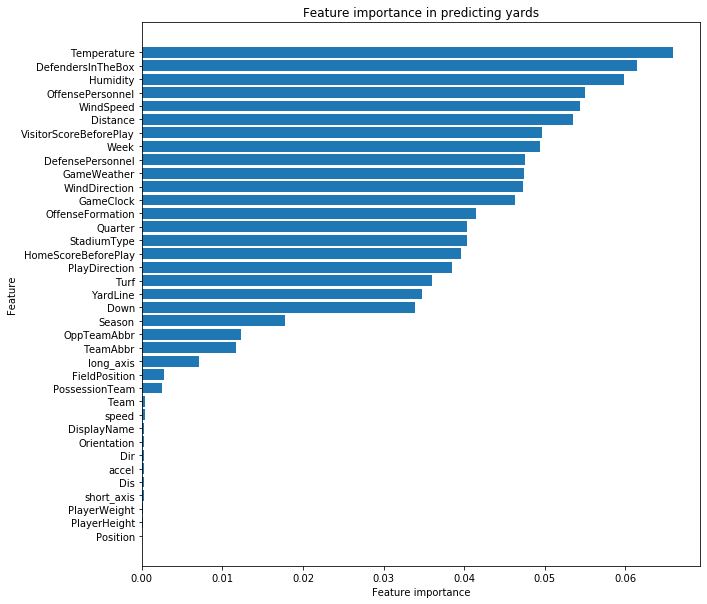

In [18]:
plot_reg_feat_imp(xgbr, X)
plt.savefig('Images/xgbr_imp.png', bbox_inches='tight');

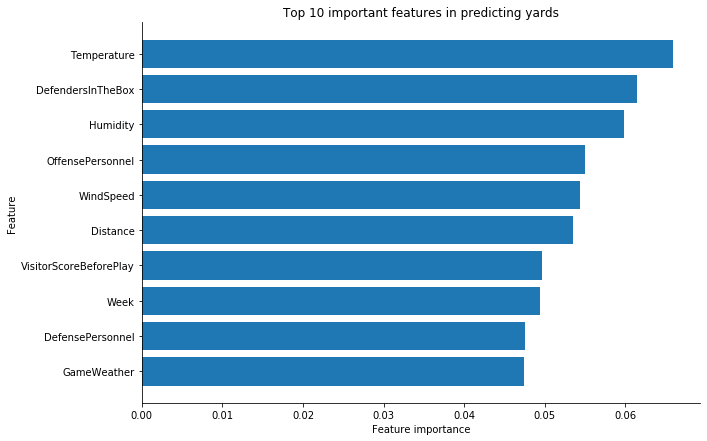

In [19]:
# top 10 important features
plot_reg_feat_imp(xgbr, X, top10=True)
sns.despine(left=False, bottom=False)
plt.savefig('Images/xgbr_imp_10.png', bbox_inches='tight');